In [9]:
# Import all packages needed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns

In [10]:
# Loading Data (data file must be in the same directory as jupyter notebook)
# Import data from excel file
raw_data_filename: str ='UV-Vis data - 2023_06_22_HWE-polymers-monomers.xlsx'

# Tell program to read the data
raw_data: pd.DataFrame = pd.read_excel(raw_data_filename)

# Output data
raw_data

,2023_06_22_C10-dialdehyde-chcl3,Unnamed: 1,2023_06_22_benzene-diphosphonate1,Unnamed: 3,2023_06_22_fluorene-diphosphonate,Unnamed: 5,2023_06_22_model-compound,Unnamed: 7,2023_06_22_AU-038-A2-3,Unnamed: 9,2023_06_22_AU-038-A3-2,Unnamed: 11,2023_06_22_AU-038-B1-2,Unnamed: 13,2023_06_22_AU-027-A4-2,Unnamed: 15
0,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs
1,700,-0.000736,700,0.000232,700,-0.000548,700,-0.000501,700,0.005895,700,0.001006,700,0.000726,700,0.001361
2,699.333313,-0.000776,699.333313,0.0002,699.333313,-0.000583,699.333313,-0.000495,699.333313,0.005836,699.333313,0.00094,699.333313,0.000706,699.333313,0.00134
3,698.666687,-0.000745,698.666687,0.000202,698.666687,-0.000557,698.666687,-0.000478,698.666687,0.005864,698.666687,0.000957,698.666687,0.000691,698.666687,0.001432
4,698,-0.000761,698,0.000205,698,-0.00058,698,-0.00045,698,0.005867,698,0.000935,698,0.000681,698,0.001356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,End Method Modifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,<Current Wavelength>,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,<SBW (nm)>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,<Energy>,1819.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
def preprocess(data: pd.DataFrame):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0)

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:")
    first_occurrence: int = indexes[indexes==0.0].index[0]
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0)

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2):
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs"
    data = data.rename(columns=column_rename)

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"})

    # Normalize absorbance values
    for col in data.columns:
        if "Abs" in col:
            max_val: float = data[col].max()
            data[col] = data[col] / max_val
    return data

preprocessed_data: pd.DataFrame = preprocess(raw_data)
preprocessed_data

,Wavelength (nm),2023_06_22_C10-dialdehyde-chcl3_Abs,2023_06_22_benzene-diphosphonate1,2023_06_22_benzene-diphosphonate1_Abs,2023_06_22_fluorene-diphosphonate,2023_06_22_fluorene-diphosphonate_Abs,2023_06_22_model-compound,2023_06_22_model-compound_Abs,2023_06_22_AU-038-A2-3,2023_06_22_AU-038-A2-3_Abs,2023_06_22_AU-038-A3-2,2023_06_22_AU-038-A3-2_Abs,2023_06_22_AU-038-B1-2,2023_06_22_AU-038-B1-2_Abs,2023_06_22_AU-027-A4-2,2023_06_22_AU-027-A4-2_Abs
1,700,-0.002166,700,0.009806,700,-0.000947,700,-0.002566,700,0.03819,700,0.006322,700,0.003548,700,0.00579
2,699.333313,-0.002284,699.333313,0.008473,699.333313,-0.001007,699.333313,-0.002535,699.333313,0.037812,699.333313,0.005909,699.333313,0.003452,699.333313,0.005698
3,698.666687,-0.002191,698.666687,0.008539,698.666687,-0.000963,698.666687,-0.002447,698.666687,0.037991,698.666687,0.006014,698.666687,0.003377,698.666687,0.006088
4,698,-0.002238,698,0.008664,698,-0.001002,698,-0.002305,698,0.038015,698,0.005878,698,0.00333,698,0.005767
5,697.333313,-0.00238,697.333313,0.007314,697.333313,-0.001066,697.333313,-0.002759,697.333313,0.037975,697.333313,0.005717,697.333313,0.00306,697.333313,0.005573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,242.666656,0.042053,242.666656,0.443412,242.666656,0.224196,242.666656,0.201231,242.666656,0.254129,242.666656,0.153312,242.666656,0.134632,242.666656,0.239502
688,241.999985,0.045038,241.999985,0.440992,241.999985,0.227996,241.999985,0.198822,241.999985,0.238007,241.999985,0.134512,241.999985,0.132567,241.999985,0.241593
689,241.333313,0.043196,241.333313,0.505186,241.333313,0.241795,241.333313,0.200102,241.333313,0.231376,241.333313,0.134982,241.333313,0.131483,241.333313,0.246613
690,240.666656,0.047822,240.666656,0.633381,240.666656,0.255531,240.666656,0.205225,240.666656,0.233809,240.666656,0.124474,240.666656,0.139367,240.666656,0.254362


(-0.01, 1.1)

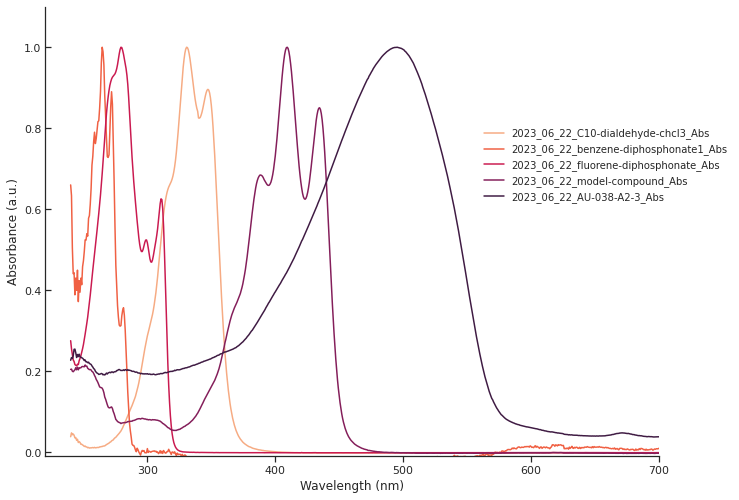

In [25]:
# Plot the data!
sample_name_to_plot: list[str] = ["2023_06_22_C10-dialdehyde-chcl3_Abs", "2023_06_22_benzene-diphosphonate1_Abs", "2023_06_22_fluorene-diphosphonate_Abs", "2023_06_22_model-compound_Abs", "2023_06_22_AU-038-A2-3_Abs"]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)

# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(preprocessed_data, id_vars=["Wavelength (nm)"], value_vars = sample_name_to_plot, var_name="sample", value_name="Absorbance (a.u.)")

# Set correct dtypes
plot_data = plot_data.astype({'Wavelength (nm)': 'float32', 'sample' : 'str', 'Absorbance (a.u.)': 'float32'})

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook")
graph = sns.lineplot(data=plot_data, x="Wavelength (nm)", y="Absorbance (a.u.)", hue="sample", palette="rocket_r")
sns.despine()
graph.legend(fontsize = 10, bbox_to_anchor= (0.7, 0.75), title_fontsize = 18, shadow = False, frameon = False)
sns.set(rc={'figure.figsize':(12,8.27)})
# Move the y-axis ticks visually to the right
graph.tick_params(axis='y', direction="in")

plt.xlim(220, 700)
plt.ylim(-0.01, 1.1)